# biochempy tutorial

This notebook demonstrate how to use biochempy.

In [935]:
%load_ext autoreload
%autoreload 2

from biochempy.plotting import *
from biochempy.optimize import *
from biochempy.model import *
from biochempy.function import *
from biochempy.equations import *
from biochempy.data import *

%matplotlib inline
import matplotlib.pyplot as plt
import corner
from lmfit import printfuncs,fit_report
from tabulate import tabulate
from copy import deepcopy

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model class

The core class of biochempy is `Model`.

A model contains all your experimental data as well as user-provided functions to reproduce your experimental data.

Simply create a model using an empty constructor.

!! It is safer to **rerun this cell every time you modify an experiment** in order to avoid adding an experiment multiple times !!

In [936]:
model=Model()
function_factory=FunctionFactory()

## Populating a model with experimental data and mathematical descriptions

Next we must populate our model with experimental data and their descriptions.

The following cell is a template of how to do so in the case that your mathematical 
description of the experiment can be provided with mathematical equations.

You can modify and copy the following cell multiple times in order to populate
your model with data from multiple experiments.

Biochempy makes a distinction between `experiment` and `replicate`:
+ an experiment consists of data description (in the form of equations of functions) and one or more dataset (replicates)
+ two replicates belong to the same experiment if their description is the same

In this case we load our experimental data from and ods file. We provide the list of files (one per replicate) 
by using a list of `fileDescriptor`s.
Each `fileDescriptor` stores the `filename`, the `sheet` where to look at the data, the columns (`cols`) containing the data and 
the variable name to be associated to those data (`header`).

Variable names can be any valid python string, with some restrictions:
+ __t__ is used to indicate time
+ __protocol__ is used to describe the different phases of an experiment
+ initial conditions (necessary when solving and ode) are described by adding to the variable name the suffix `_0`
+ variables whose value can differ in different replicate (e.g. initial concentrations) are described by adding to the variable name the suffix `_repX`, with X the index of the replicate

In this example the experiment is composed of alternating `dark` and `light` phases, so the protocol column contains a sequence of 'dark' and 'light' strings. If your experiment is composed of a single phase and you do not provide a 'protocol' column, the phase name will be assigned automatically to 'default'.

The `equations` provide a mathematical descriptions for any quantity of the system.
Different phases can have (and usually have) different mathematical descriptions. In this case the rate km4 in the 'dark' phase becomes 'knu' in the 'light' one.

The `constrains` provide an easy way to make substitutions inside your equations. 
In our case we impose the conservation of charges (first constraint), conservation of mass (second constraint),
equilibrium condition (last constraint) and some other definitions. Each one of these constraints will be substituted in order in any of your equations before anythig else.

Last we tell the system which `observables` we want to reproduce with our description and which parameters can be used to fit the description to the data (`variables`).

A report of everything you provided is eventually shown after you run the cell, so you can manually check everything is fine.

In [937]:
experiment_name="pHjumps"

filedescr=[{'filename':"../n1_rep1_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'},
           {'filename':"../n1_rep2_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'}
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
             "MCH_0=(Ctot-H1)-cMCH_0",
             "cMCH_0=(Ctot-H1)/(1.+1./Ka*Ksp*Kd)",
             "SP_0=H1-MC_0",
             "MC_0=H1/(1+Ksp)",
             "H1=0.5*(sqrt((Ka+Ka*Ksp)**2+4*(1+Ka*Ksp*Kd)*(Ka+Ka*Ksp)*Ctot)-(Ka+Ka*Ksp))/(1+Ka*Ksp*Kd)"
            ]

observables=['pH','MCH','MC','SP','cMCH','H']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

model.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'knu', 'k4', 'k3', 't', 'Kd']
['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'knu', 'k4', 'k3', 't', 'Kd']

['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'knu', 'k4', 'k3', 't', 'Kd']
['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'knu', 'k4', 'k3', 't', 'Kd']



Sometimes the description of the experiment can not be provided in the form of mathematical equations or first order differential equation.

This is the case, for example, of our observable 'kobs', wich is the second eigenvalue of the rate matrix of our system.

In such cases we can provide biochempy with a simple python function and use that in our model.

In [938]:
from numpy import linalg as LA
from functools import partial

experiment_name="kobs"

filedescr=[{'filename':"../n1_kobs_rep1.ods",'sheet':"Sheet1",'cols':[0,1,2],'header':['pH','kobs','kobs_err'],'delimiter':';'},
          ]

def function(pH,k1,k2,k3,k4,Ka,Ksp,Kd):
    def exponential(x,l,a0):
        return a0*np.exp(-x*l)
    km1=k1/Ka
    km2=k2/Ksp
    km3=k3/Kd
    km4=k4*Ka*Ksp*Kd
    Hl=(10**-pH).tolist()
    ret=[]
    r1=0
    r2=30
    for H in Hl:
        R=np.array([[-k1-km4,km1*H     ,0.        ,k4],
                   [k1      ,-km1*H-k2 ,km2       ,0.],
                   [0.      ,k2        ,-km2-k3*H ,km3],
                   [km4     ,0.        ,k3*H      ,-k4-km3]])
        val,vec=LA.eig(R)
        c0=LA.solve(vec,np.array([0.,0.,1.,0.]))
        MCHeq=np.dot(vec,c0*np.exp(val*10000))[0]
        MCHt=np.array( [ MCHeq - np.dot(vec,c0*np.exp(val*t))[0] for t in np.linspace(0,100,100) ] )
        expa0=partial(exponential,a0=MCHeq)
        opt,cov=curve_fit(expa0,np.linspace(0,100,100)[r1:r2],MCHt[r1:r2],(0.08),method='lm')
        ret.append(opt[0])
    return np.array(ret)
function_signature=['pH','k1','k2','k3','k4','Ka','Ksp','Kd']
function_out=['kobs']

observables=['kobs']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

#constraints=[Equation(s) for s in constraints]
#equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
#equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

#ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
#ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
#equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

equations={}
constraints={}
functions={'default':[function_factory.buildPythonGenericFunction(function_out,function_signature,function,False)]}

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

model.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ka', 'k2', 'k1', 'pH', 'Ksp', 'k4', 'k3', 'Kd']
['Ka', 'k2', 'k1', 'pH', 'Ksp', 'k4', 'k3', 'Kd']



In [939]:
from numpy import linalg as LA

experiment_name="kobsh"

filedescr=[{'filename':"../n1_hydrolysis.ods",'sheet':"Sheet1",'cols':[0,5,7],'header':['pH','kobsh','kobsh_err'],'delimiter':';'},
          ]

def function(pH,k1,k2,k3,k4,Ka,Ksp,Kd,kh2o,kmh2o,koh,kmoh,khp,kmhp):
    km1=k1/Ka
    km2=k2/Ksp
    km3=k3/Kd
    km4=k4*Ka*Ksp*Kd
    Hl=(10**-pH).tolist()
    ret=[]
    r1=1
    r2=10
    for H in Hl:
        OH=1.0e-14/H
        R=np.array([
                   [-k1-km4-kh2o-koh*OH ,km1*H     ,0.        ,k4      ,kmh2o*H+kmoh     , 0.],
                   [k1                  ,-km1*H-k2 ,km2       ,0.      ,0.               , 0.],
                   [0.                  ,k2        ,-km2-k3*H ,km3     ,0.               , 0.],
                   [km4                 ,0.        ,k3*H      ,-k4-km3 ,0.               , 0.],
                   [kh2o+koh*OH         ,0.        ,0.        ,0.      ,-kmh2o*H-kmoh-khp, kmhp],
                   [0.                  ,0.        ,0.        ,0.      ,khp              ,-kmhp],
                   ])
        v=sorted(LA.eigvals(R).tolist())[-2]
        ret.append(-v)
    return np.array(ret)
function_signature=['pH','k1','k2','k3','k4','Ka','Ksp','Kd','kh2o','kmh2o','koh','kmoh','khp','kmhp']
function_out=['kobsh']

observables=['kobsh']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

#constraints=[Equation(s) for s in constraints]
#equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
#equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

#ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
#ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
#equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

equations={}
constraints={}
functions={'default':[function_factory.buildPythonGenericFunction(function_out,function_signature,function,False)]}

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

model.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ka', 'k2', 'koh', 'k1', 'kmoh', 'kmh2o', 'kmhp', 'pH', 'Ksp', 'khp', 'k4', 'k3', 'Kd', 'kh2o']
['Ka', 'k2', 'koh', 'k1', 'kmoh', 'kmh2o', 'kmhp', 'pH', 'Ksp', 'khp', 'k4', 'k3', 'Kd', 'kh2o']



## Providing initial data
 information about experiment data. Data can be initialized passing the following quantities:
After your model if populated with all your data and descriptions, it is time to provide some values for all model parameters.

`Data` is a class that stores
+ `value`: the value of that parameter.
+ `error`: the error associated with that value. Default is None.
+ `minv` : the minimumm possible value for that parameter. Default is 0.
+ `maxv` : the maximumm possible value for that parameter. Default is None.

During a fit, if a parameter is in the `variables` list, a gaussian prior will be used if an error is provided. Otherwise a flat prior will be used in the allowed region

In [940]:
Ka=1.25455087/19889081.3
Ksp=0.08855158/0.00303546
Kd=138
Ctot_1=0.00050987706
Ctot_2=0.00060099951
k2=0.08855158

init_data={}
init_data['Ctot_rep1'] = Data(Ctot_1,minv=Ctot_1*0.5,maxv=Ctot_1*1.5)
init_data['Ctot_rep2'] = Data(Ctot_2,minv=Ctot_2*0.5,maxv=Ctot_2*1.5)
init_data['Ka'] = Data(Ka,minv=Ka*0.8,maxv=Ka*1.2)
init_data['Ksp'] = Data(Ksp,minv=Ksp*0.8,maxv=Ksp*1.2)
init_data['Kd'] = Data(Kd,minv=Kd*0.8,maxv=Kd*1.2)
init_data['k1'] = Data(1.25455087,minv=0.)
init_data['k2'] = Data(k2,minv=k2*0.7,maxv=k2*1.3)
init_data['k3'] = Data(0.06883960,minv=0.)
init_data['knu'] = Data(0.04,minv=0.)
init_data['k4'] = Data(0.005
                       ,minv=0.)

init_data['kh2o'] = Data(0.006011,minv=0.)
init_data['kmh2o'] = Data(1.553e+05,minv=0.)
init_data['koh'] = Data(0.,minv=0.)
init_data['kmoh'] = Data(0.,minv=0.)
init_data['khp'] = Data(0.1482,minv=0.)
init_data['kmhp'] = Data(1.047e-11,minv=0.)

variables=['Ka','Ksp','Kd','k1','k2','k3','k4','knu','Ctot_rep1','Ctot_rep2','kh2o','kmh2o','khp','kmhp']
#variables=['Ka','Ksp','Kd','k1','k2','k3','k4','Ctot_rep1','Ctot_rep2','kh2o','kmh2o','khp','kmhp']
print(Ka,Ksp,Kd,init_data['k4'].value*Ka*Ksp*Kd)

6.307736647443842e-08 29.17237585077715 138 1.269680483303974e-06


## Fitting the model to data

The fitting procedure can be customized.
Here we show a simple example in which we fit the model by
+ run a first corse but robust optimization using the 'nelder' algorithm
+ refine the minimum by running a 'lbfgsb' minimization
+ running emcee to explore the parameter space around the minimum. This is useful in order to check 
the presence of multiple minima, determine the correlations between free parameters and estimate 
the errors on the fitted values

The following parameters customize this minimization protocol.

In [941]:
nsteps_nelder=1000
nsteps_lbfgsb=12000
nsamples_emcee=10000
burn_emcee=50
thin_emcee=1
nwalkers_emcee=50

opt=Optimize(model,init_data,variables)

### Run Nelder minimizer

In [942]:
res_nelder=opt.minimize(maxiter=nsteps_nelder,replicas=100)




  0%|          | 0/99 [00:00<?, ?it/s]


  1%|          | 1/99 [01:24<2:18:43, 84.93s/it]


  2%|▏         | 2/99 [02:50<2:17:27, 85.03s/it]


  3%|▎         | 3/99 [04:15<2:16:24, 85.26s/it]


  4%|▍         | 4/99 [05:38<2:13:28, 84.30s/it]


  5%|▌         | 5/99 [07:01<2:11:28, 83.92s/it]


  6%|▌         | 6/99 [08:24<2:09:52, 83.79s/it]


  7%|▋         | 7/99 [09:47<2:08:03, 83.51s/it]


  8%|▊         | 8/99 [11:10<2:06:37, 83.49s/it]


  9%|▉         | 9/99 [12:38<2:06:53, 84.60s/it]


 10%|█         | 10/99 [14:02<2:05:35, 84.66s/it]


 11%|█         | 11/99 [15:28<2:04:40, 85.00s/it]


 12%|█▏        | 12/99 [16:54<2:03:27, 85.15s/it]


 13%|█▎        | 13/99 [18:34<2:08:30, 89.66s/it]


 14%|█▍        | 14/99 [20:06<2:08:10, 90.48s/it]


 15%|█▌        | 15/99 [21:33<2:05:15, 89.47s/it]


 16%|█▌        | 16/99 [23:08<2:06:00, 91.09s/it]


 17%|█▋        | 17/99 [24:45<2:06:50, 92.81s/it]


 18%|█▊        | 18/99 [26:17<2:04:55, 92.53s/it]


 19%|█▉        | 19/99 [27:58

In [943]:
best_params=res_nelder.params
print(best_params.pretty_print())
with open('n1_nelder.params','w') as outfile:
    best_params.dump(outfile)

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
Ctot_rep1  0.0005075 0.0002549 0.0007648     None     True     None     None
Ctot_rep2  0.0006517 0.0003005 0.0009015     None     True     None     None
Ka         5.938e-08 5.046e-08 7.569e-08     None     True     None     None
Kd            133.5    110.4    165.6     None     True     None     None
Ksp           27.58    23.34    35.01     None     True     None     None
k1            4.532        0      inf     None     True     None     None
k2          0.09127  0.06199   0.1151     None     True     None     None
k3             2.29        0      inf     None     True     None     None
k4         0.0001181        0      inf     None     True     None     None
kh2o       6.252e-05        0      inf     None     True     None     None
khp          0.3025        0      inf     None     True     None     None
kmh2o      2.078e+05        0      inf     None     True     None     None
kmhp        2.2e-12     

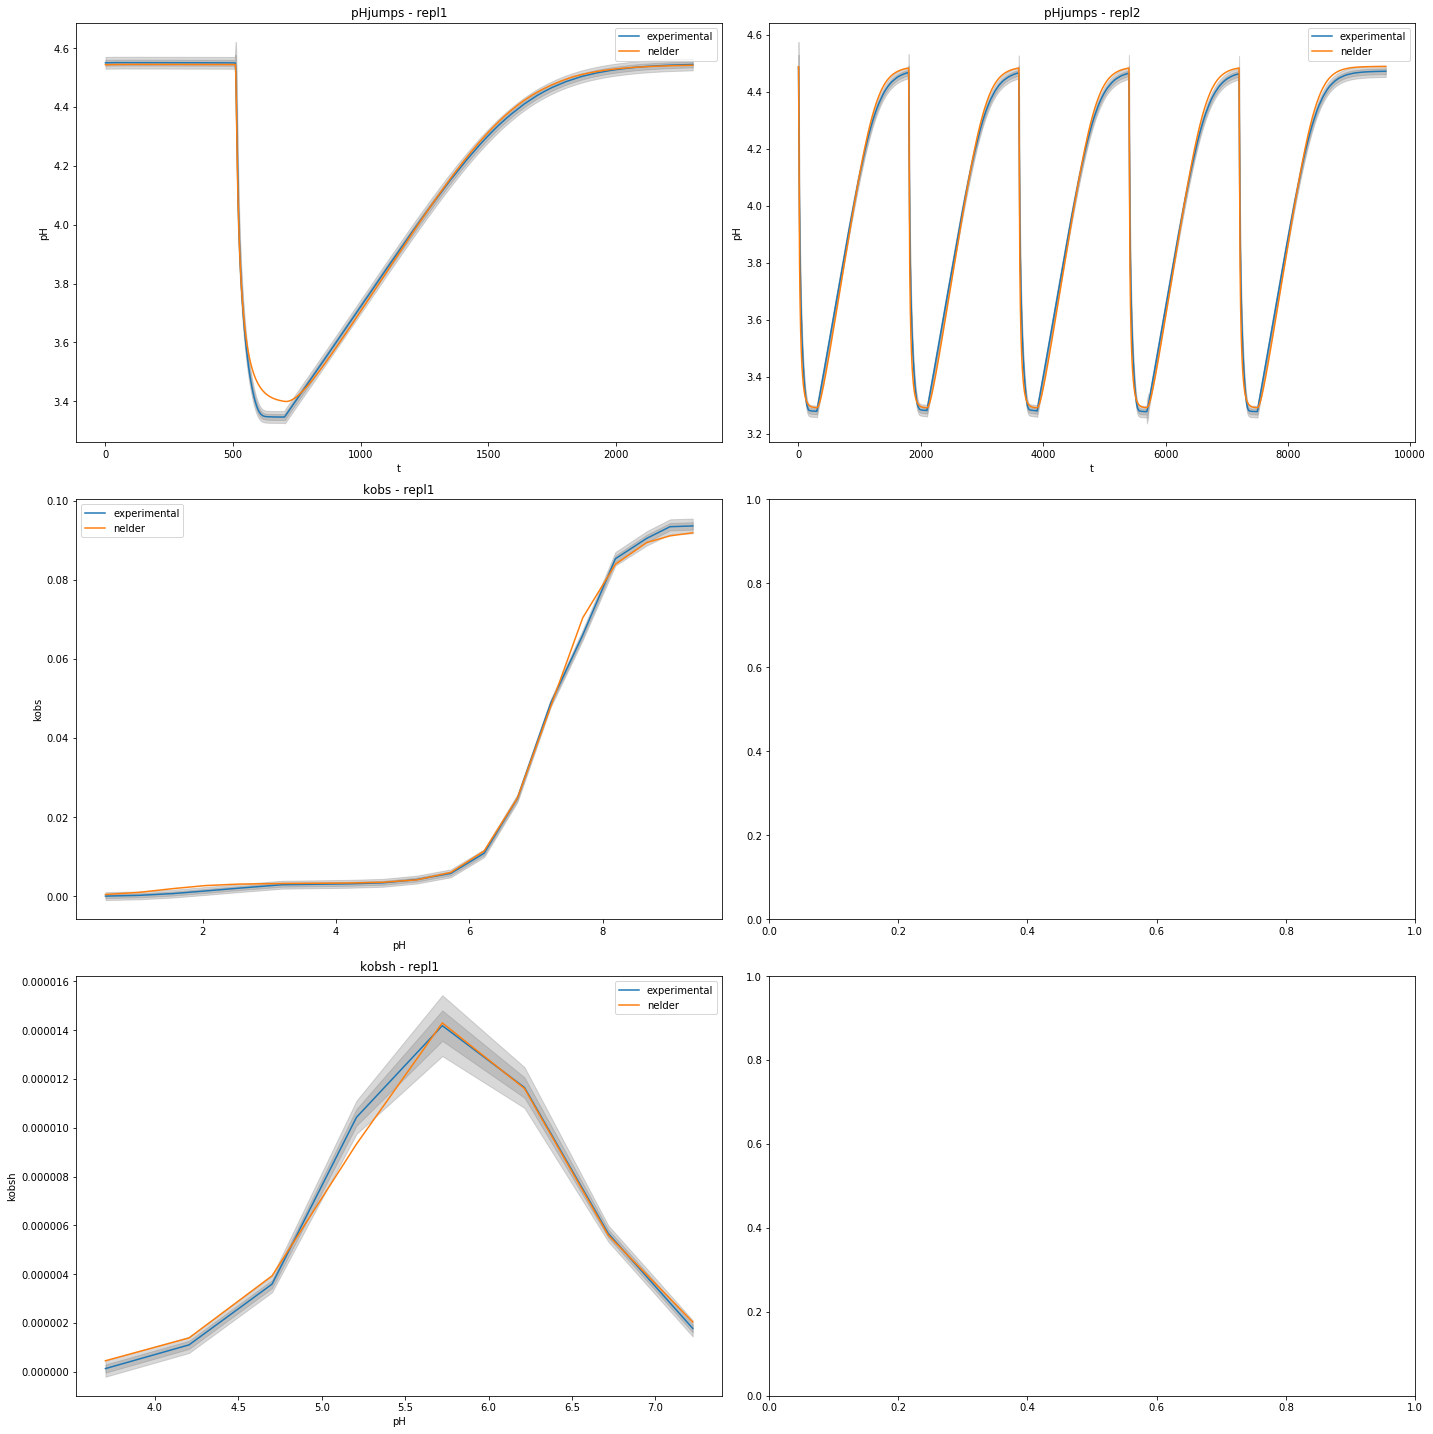

In [944]:
plotModel(model,params=[ (best_params,'nelder') ],plots=[ [('t','pH')],[('pH','kobs')],[('pH','kobsh')] ])
#plotModel(model,params=[ (best_params,'nelder') ],plots=[ [('t','pH')],[('pH','kobsh')] ])
plt.savefig('n1_nelder.png')

### Run lbfgs-b minimizer

In [945]:
from lmfit import Parameters
best_params=Parameters()
with open('n1_nelder.params') as infile:
    best_params.load(infile)
res_lbfgsb=opt.minimize(method='lbfgsb',maxiter=nsteps_lbfgsb,params=best_params)

In [946]:
best_params=res_lbfgsb.params
print(best_params.pretty_print())
with open('n1_lbfgsb.params','w') as outfile:
    best_params.dump(outfile)

rows=[]
for key in best_params.valuesdict():
    rows.append( [key,best_params[key].value] )
with open('n1_lbfgsb.txt','w') as outfile:
    outfile.write(tabulate(rows, headers=['Name', 'Value']))

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
Ctot_rep1  0.0005075 0.0002549 0.0007648     None     True     None     None
Ctot_rep2  0.0006517 0.0003005 0.0009015     None     True     None     None
Ka         5.938e-08 5.046e-08 7.569e-08     None     True     None     None
Kd            133.5    110.4    165.6     None     True     None     None
Ksp           27.58    23.34    35.01     None     True     None     None
k1            4.532        0      inf     None     True     None     None
k2          0.09127  0.06199   0.1151     None     True     None     None
k3             2.29        0      inf     None     True     None     None
k4         0.0001181        0      inf     None     True     None     None
kh2o       6.252e-05        0      inf     None     True     None     None
khp          0.3025        0      inf     None     True     None     None
kmh2o      2.078e+05        0      inf     None     True     None     None
kmhp        2.2e-12     

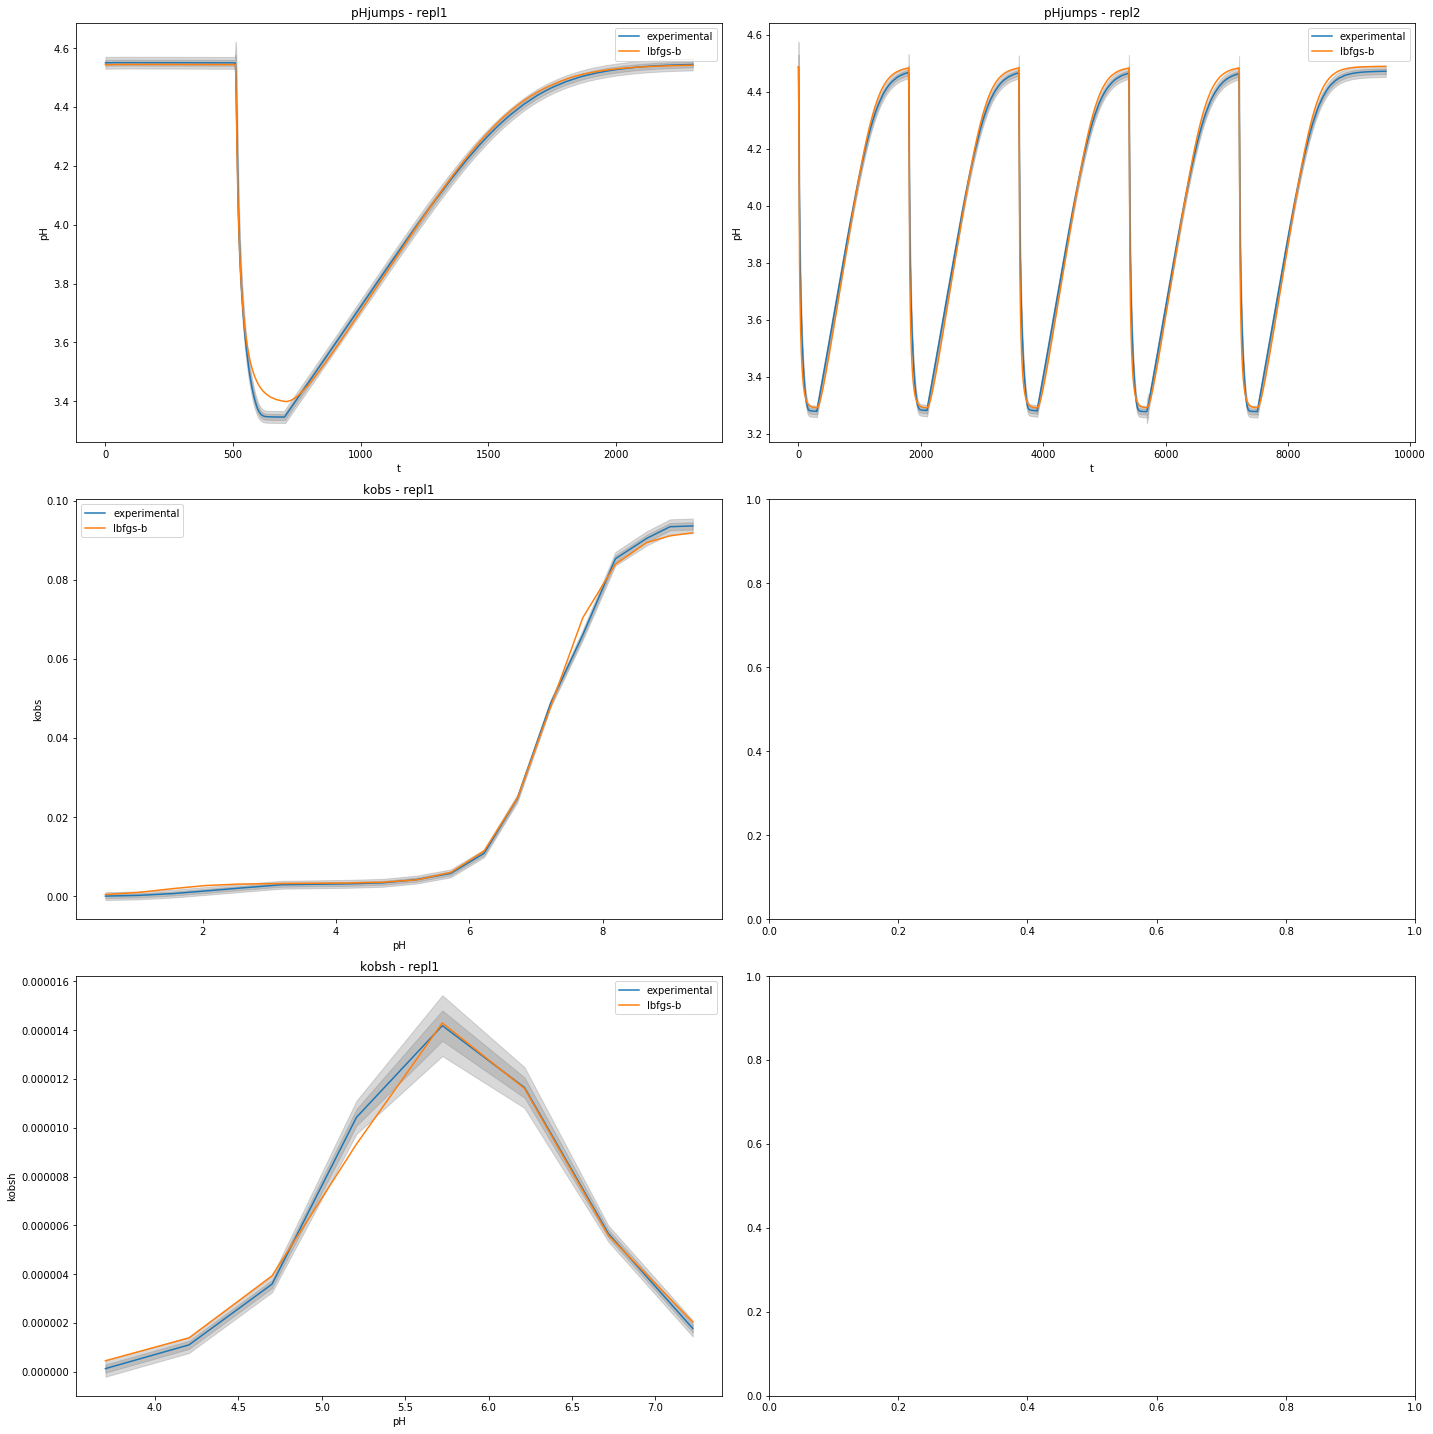

In [947]:
plotModel(model,params=[ (best_params,'lbfgs-b') ],plots=[ [('t','pH')],[('pH','kobs')],[('pH','kobsh')] ])
#plotModel(model,params=[ (best_params,'lbfgs-b') ],plots=[ [('t','pH')],[('pH','kobsh')] ])
plt.savefig("n1_lbfgsb.png")

### Run emcee (can take ~1 h)

In [13]:
res_emcee = opt.sampleMCMC(res_lbfgsb,workers=1,burn=burn_emcee,steps=nsamples_emcee,thin=thin_emcee,nwalkers=nwalkers_emcee)

 13%|█▎        | 1354/10150 [29:40<3:10:01,  1.30s/it]/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<lambdifygenerated-5>:2: RuntimeWarning: invalid value encountered in log10
  return (-numpy.log10(H))
 19%|█▉        | 1914/10150 [42:12<3:46:56,  1.65s/it]/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 20%|█▉        | 2023/10150 [45:01<3:37:03,  1.60s/it]<lambdifygenerated-17>:2: RuntimeWarning: invalid value encountered in log10
  return (-numpy.log10(H))
100%|██████████| 10150/10150 [3:53:27<00:00,  1.38s/it] 


AttributeError: 'MinimizerResult' object has no attribute 'variables'

In [ ]:
emcee_plot = corner.corner(res_emcee[0], labels=res_emcee[1],truths=res_emcee[2])
plt.savefig('n1_emcee.png')

data=[]
for i in range(len(res_emcee[1])):
    mcmc = np.percentile(res_emcee[0][:, i], [16, 50, 84])
    data.append( [res_emcee[1][i],mcmc[1],mcmc[0],mcmc[2]] )

with open('n1_emcee_error.txt','w') as outfile:
    outfile.write(tabulate(data, headers=['Name', 'Value', '16th perc.', '84th perc.']))


### Validation

Reproduce all your data by using random parameters sampled by emcee.

In [ ]:
ncurves=1000
predictions_mcmc=[[{k:[] for k in repl.data.keys()} for repl in exp.replicates] for exp in model.experiments]
inds = np.random.randint(len(res_emcee[0]), size=ncurves)
params=[opt.listToParams(res_emcee[0][i]) for i in inds]

plotPredictionErrors(model,params=params,plots=[ [('t','pH')],[('pH','kobs')],[('pH','kobsh')] ],width=20,height=20,pad=1.0,fontsize=20)
plt.savefig('n1_validate_errors.png')

## Compute Quantum Yield at stationarity (according to model)

In [948]:
def quantumYield(dt,dH):
    power=340*1e-3    # 340mW
    wavelength=425e-9 # 425nm
    nu=299792458./wavelength           # light frequency = c/wavelength
    photon_energy=6.62607004e-34*nu    # h*nu
    photons = power*dt/photon_energy   # energy / energy of one photon
    
    qy = dH/photons # this is the number of H+ produced by one photon
    return qy

def reportQYValues(protocol,qy):
    idxs=[]
    for i in range(protocol.shape[0]-1):
        if protocol[i]=='light' and protocol[i+1]=='dark':
            idxs.append(i-1)
    return qy[idxs]

res=model.predict(best_params)
exp1=res[0][0]
exp2=res[0][1]

fluxH1=+exp1['cMCH'].value*best_params['k3'].value/best_params['Kd'].value
fluxH2=+exp2['cMCH'].value*best_params['k3'].value/best_params['Kd'].value

qy1=quantumYield( np.diff(exp1['t'].value),fluxH1[1:]*6.022e23*30e-3 )*100
qy2=quantumYield( np.diff(exp2['t'].value),fluxH2[1:]*6.022e23*30e-3 )*100

val1=np.mean(reportQYValues(model.experiments[0].replicates[0].data['protocol'].value,qy1))
val2=np.mean(reportQYValues(model.experiments[0].replicates[1].data['protocol'].value,qy2))

with open('n1_qy_model.txt','w') as outfile:
    outfile.write("QY repl1: {}\n".format(val1))
    outfile.write("QY repl2: {}\n".format(val2))

## Compute Quantum Yield from data

In [949]:
from scipy.optimize import curve_fit

def exponential(x,a,b):
    return a*np.exp(x*b)

def quantumYield(t,protocol,pH):
    idx_dark=[]
    idx_light=[]
    for i in range(protocol.shape[0]-1):
        if protocol[i]=='dark' and protocol[i+1]=='light':
            idx_dark.append(i)
        if protocol[i]=='light' and protocol[i+1]=='dark':
            idx_light.append(i)
    if idx_dark[0] > idx_light[0]:
        idx_dark=[0]+idx_dark
    l=min( len(idx_dark),len(idx_light) )
    idx_dark=idx_dark[:l]
    idx_light=idx_light[:l]
    
    pHdark=np.mean(pH[idx_dark])
    pHlight=np.mean(pH[idx_light])
    
    DeltaH=( 10**(-pHlight)-10**(-pHdark) )*6.022e23*30e-3
    
    power=340*1e-3    # 340mW
    wavelength=425e-9 # 425nm
    nu=299792458./wavelength           # light frequency = c/wavelength
    photon_energy=6.62607004e-34*nu    # h*nu
    photon_rate = power/photon_energy   # energy rate / energy of one photon
    
    tau=[]
    for i in range(l):
        xdata=t[idx_dark[i]:idx_light[i]]-t[idx_dark[i]]
        ydata=10**-pH[idx_dark[i]:idx_light[i]]
        tt=xdata[np.argwhere(ydata > ydata[-1]-(ydata[-1]-ydata[0])/100  )[0]]
        tau.append(tt)
    tau=np.mean(tau)
    photons=photon_rate*tau
    qy=DeltaH/photons
    return qy*100

qy1=quantumYield(model.experiments[0].replicates[0].data['t'].value,model.experiments[0].replicates[0].data['protocol'].value,model.experiments[0].replicates[0].data['pH'].value)
qy2=quantumYield(model.experiments[0].replicates[1].data['t'].value,model.experiments[0].replicates[1].data['protocol'].value,model.experiments[0].replicates[1].data['pH'].value)


with open('n1_qy_data.txt','w') as outfile:
    outfile.write("QY repl1: {}\n".format(qy1))
    outfile.write("QY repl2: {}\n".format(qy2))

## Comparison with hydrolysis from approximated formula (neutral pH)

In [950]:
def kobsH(pH,params):
    H=10**-pH
    kh2o=params['kh2o']
    khp=params['khp']
    kmh2o=params['kmh2o']
    Kgs=params['Ka']*params['Ksp']
    print(Kgs)
#    print(khp.value)
#    print(kh2o.value)
    return kh2o*khp*H/( (H+Kgs)*(kmh2o*H+khp) )

In [951]:
from lmfit import Parameters
best_params=Parameters()
with open('n1_lbfgsb.params') as infile:
    best_params.load(infile)

In [956]:
hydr=kobsH(model.experiments[2].replicates[0].data['pH'].value,best_params)
mdl = model.experiments[2].predict(best_params)

1.6377410435714388e-06


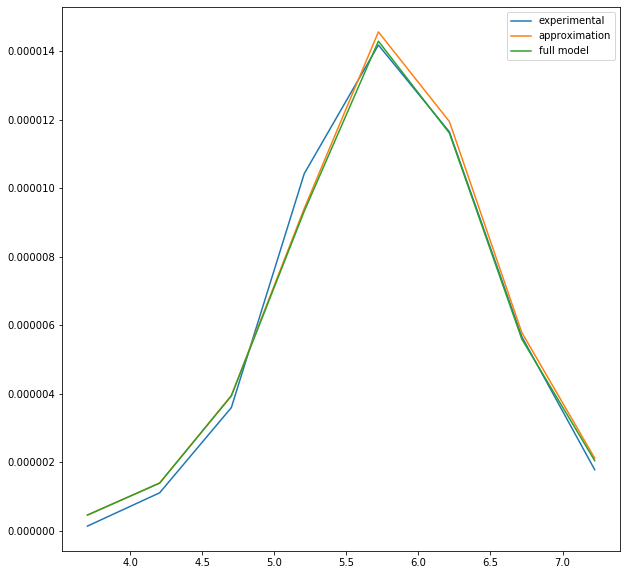

In [957]:
plt.rcParams['figure.figsize']=(10,10)
plt.plot(model.experiments[2].replicates[0].data['pH'].value,model.experiments[2].replicates[0].data['kobsh'].value, label='experimental')
plt.plot(model.experiments[2].replicates[0].data['pH'].value,hydr,label='approximation')
plt.plot(model.experiments[2].replicates[0].data['pH'].value,mdl[0]['kobsh'].value, label='full model')
plt.legend()
plt.savefig('n1_kobsh_comparison.png')

## Timescale studies

In [910]:
from functools import partial
def exponential(x,l,a0):
    return a0*np.exp(-x*l)

def linear(x,l):
    return -x*l

def rates6(pH,params):
    k1=params['k1']
    k2=params['k2']
    k3=params['k3']
    k4=params['k4']
    Ka=params['Ka']
    Ksp=params['Ksp']
    Kd=params['Kd']
    kh2o=params['kh2o']
    kmh2o=params['kmh2o']
    koh=params['koh']
    kmoh=params['kmoh']
    khp=params['khp']
    kmhp=params['kmhp']
    
    km1=k1/Ka
    km2=k2/Ksp
    km3=k3/Kd
    km4=k4*Ka*Ksp*Kd
    Hl=(10**-pH).tolist()
    ret=[]
    for H in Hl:
        OH=1.0e-14/H
        R=np.array([
                   [-k1-km4-kh2o-koh*OH ,km1*H     ,0.        ,k4      ,kmh2o*H+kmoh     , 0.],
                   [k1                  ,-km1*H-k2 ,km2       ,0.      ,0.               , 0.],
                   [0.                  ,k2        ,-km2-k3*H ,km3     ,0.               , 0.],
                   [km4                 ,0.        ,k3*H      ,-k4-km3 ,0.               , 0.],
                   [kh2o+koh*OH         ,0.        ,0.        ,0.      ,-kmh2o*H-kmoh-khp, kmhp],
                   [0.                  ,0.        ,0.        ,0.      ,khp              ,-kmhp],
                   ])
        val,vec=LA.eig(R)
        ret.append(-val)
    return np.array(ret)

def rates4(pH,params):
    k1=params['k1']
    k2=params['k2']
    k3=params['k3']
    k4=params['k4']
    Ka=params['Ka']
    Ksp=params['Ksp']
    Kd=params['Kd']
    kh2o=params['kh2o']
    kmh2o=params['kmh2o']
    koh=params['koh']
    kmoh=params['kmoh']
    khp=params['khp']
    kmhp=params['kmhp']
    
    km1=k1/Ka
    km2=k2/Ksp
    km3=k3/Kd
    km4=k4*Ka*Ksp*Kd
    Hl=(10**-pH).tolist()
    
    r1=0
    r2=100
    ret=[]
    for H in Hl:
        R=np.array([[-k1-km4,km1*H     ,0.        ,k4],
                   [k1      ,-km1*H-k2 ,km2       ,0.],
                   [0.      ,k2        ,-km2-k3*H ,km3],
                   [km4     ,0.        ,k3*H      ,-k4-km3]])
        val,vec=LA.eig(R)
        ret.append(-val)
    return np.array(ret)

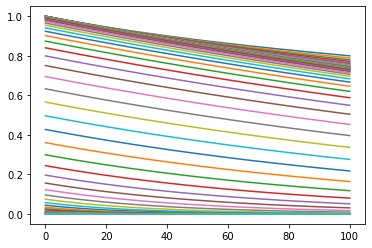

In [911]:
r4=rates4(np.linspace(1,13,100),best_params)

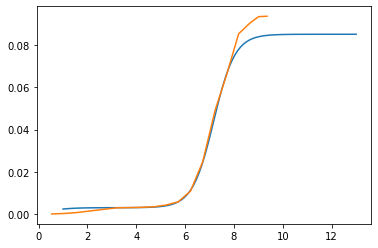

In [912]:
_=plt.plot(np.linspace(1,13,100),r4)
_=plt.plot(model.experiments[1].replicates[0].data['pH'].value,model.experiments[1].replicates[0].data['kobs'].value)

## Variable power

In [958]:
modelvp=Model()

In [959]:
experiment_name="p0"

filedescr=[{'filename':"../n1_rep1_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'},
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu340*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu340*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
             "MCH_0=(Ctot-H1)-cMCH_0",
             "cMCH_0=(Ctot-H1)/(1.+1./Ka*Ksp*Kd)",
             "SP_0=H1-MC_0",
             "MC_0=H1/(1+Ksp)",
             "H1=0.5*(sqrt((Ka+Ka*Ksp)**2+4*(1+Ka*Ksp*Kd)*(Ka+Ka*Ksp)*Ctot)-(Ka+Ka*Ksp))/(1+Ka*Ksp*Kd)"
            ]

observables=['pH','MCH','MC','SP','cMCH','H']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

modelvp.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'k4', 'k3', 't', 'Kd', 'knu340']
['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'k4', 'k3', 't', 'Kd', 'knu340']



In [960]:
experiment_name="p1"

filedescr=[{'filename':"../n1_P272_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'}
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu272*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu272*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
             "MCH_0=(Ctot-H1)-cMCH_0",
             "cMCH_0=(Ctot-H1)/(1.+1./Ka*Ksp*Kd)",
             "SP_0=H1-MC_0",
             "MC_0=H1/(1+Ksp)",
             "H1=0.5*(sqrt((Ka+Ka*Ksp)**2+4*(1+Ka*Ksp*Kd)*(Ka+Ka*Ksp)*Ctot)-(Ka+Ka*Ksp))/(1+Ka*Ksp*Kd)"
            ]

observables=['pH','MCH','MC','SP','cMCH','H']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

modelvp.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'k4', 'knu272', 'k3', 't', 'Kd']
['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'k4', 'knu272', 'k3', 't', 'Kd']



In [961]:
experiment_name="p2"

filedescr=[{'filename':"../n1_P204_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'}
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu204*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu204*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
             "MCH_0=(Ctot-H1)-cMCH_0",
             "cMCH_0=(Ctot-H1)/(1.+1./Ka*Ksp*Kd)",
             "SP_0=H1-MC_0",
             "MC_0=H1/(1+Ksp)",
             "H1=0.5*(sqrt((Ka+Ka*Ksp)**2+4*(1+Ka*Ksp*Kd)*(Ka+Ka*Ksp)*Ctot)-(Ka+Ka*Ksp))/(1+Ka*Ksp*Kd)"
            ]

observables=['pH','MCH','MC','SP','cMCH','H']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

modelvp.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'k4', 'k3', 'knu204', 't', 'Kd']
['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'k4', 'k3', 'knu204', 't', 'Kd']



In [962]:
experiment_name="p3"

filedescr=[{'filename':"../n1_P136_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'}
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu136*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu136*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
             "MCH_0=(Ctot-H1)-cMCH_0",
             "cMCH_0=(Ctot-H1)/(1.+1./Ka*Ksp*Kd)",
             "SP_0=H1-MC_0",
             "MC_0=H1/(1+Ksp)",
             "H1=0.5*(sqrt((Ka+Ka*Ksp)**2+4*(1+Ka*Ksp*Kd)*(Ka+Ka*Ksp)*Ctot)-(Ka+Ka*Ksp))/(1+Ka*Ksp*Kd)"
            ]

observables=['pH','MCH','MC','SP','cMCH','H']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

modelvp.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'knu136', 'k4', 'k3', 't', 'Kd']
['Ctot', 'Ka', 'k2', 'k1', 'Ksp', 'knu136', 'k4', 'k3', 't', 'Kd']



In [963]:
experiment_name="p4"

filedescr=[{'filename':"../n1_P68_wprotocol.ods",'sheet':"Sheet 1",'cols':[0,1,2,3],'header':['t','pH','pH_err','protocol'],'delimiter':';'}
          ]


equations={'dark': ["MCH'=km1*MC*H+k4*cMCH-k1*MCH-km4*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=km4*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ],
           'light':["MCH'=km1*MC*H+k4*cMCH-k1*MCH-knu68*MCH",
                    "MC'=k1*MCH+km2*SP-km1*MC*H-k2*MC",
                    "SP'=k2*MC+km3*cMCH-k3*SP*H-km2*SP",
                    "cMCH'=knu68*MCH+k3*SP*H-k4*cMCH-km3*cMCH",
                   ]
          }

constraints=["H=SP+MC+1e-7",
             "MCH=Ctot-SP-MC-cMCH",
             "pH=-log10(H)",
             "km1=k1/Ka",
             "km2=k2/Ksp",
             "km3=k3/Kd",
             "km4=k4*Ka*Ksp*Kd",
             "MCH_0=(Ctot-H1)-cMCH_0",
             "cMCH_0=(Ctot-H1)/(1.+1./Ka*Ksp*Kd)",
             "SP_0=H1-MC_0",
             "MC_0=H1/(1+Ksp)",
             "H1=0.5*(sqrt((Ka+Ka*Ksp)**2+4*(1+Ka*Ksp*Kd)*(Ka+Ka*Ksp)*Ctot)-(Ka+Ka*Ksp))/(1+Ka*Ksp*Kd)"
            ]

observables=['pH','MCH','MC','SP','cMCH','H']

display_report=False
###########################################
# Do not change anything below this line! #
###########################################

loader=ODSDataLoader( [DataFileDescriptor(**fd) for fd in filedescr ] )

constraints=[Equation(s) for s in constraints]
equations = {k:[Equation(e) for e in eqs] for k,eqs in equations.items()}
equations = {k:applyConstraints(eqs,constraints) for k,eqs in equations.items()}

ode={k:[eq for eq in eqs if eq.dout_dt] for k,eqs in equations.items() }
ode_deps={k:list(set([dep for eq in eqs for dep in eq.dependencies])) for k,eqs in ode.items()}
equations={k:[eq for eq in eqs if not eq.dout_dt] for k,eqs in equations.items() }

ode_f={k:function_factory.buildODEFunction(eqs,ode_deps[k]) for k,eqs in ode.items()}
functions={k:[function_factory.buildSympyGenericFunction(eq,eq.dependencies) for eq in eqs] for k,eqs in equations.items()}
for k,eqs in ode_f.items():
    if k in functions.keys():
        functions[k].append(eqs)
    else:
        functions[k]=[eqs]

experiment=Experiment(functions,observables,experiment_name)

for d in loader.getData():
    experiment.addReplicate(d)

modelvp.addExperiment(deepcopy(experiment))

##################################
# Check and Report provided data #
##################################
if display_report:
    printmd("# Report for experiment '**{}**'".format(experiment_name))
    print()

    # 1) check that equations are provided for every phase defined in the protocol
    try:
        phases=np.unique(np.stack([ repl.data['protocol'].value for repl in experiment.replicates if 'protocol' in repl.data.keys() ]))
    except:
        phases=['default']
    for phase in phases:
        if phase not in functions.keys():
            raise RuntimeError("Error: you must provide equations for phase {}".format(phase))
    printmd("Your experiment is composed of **{}** phases: {}".format(len(phases),", ".join(["**{}**".format(p) for p in phases])))
    print()

    # 2) display all provided equations
    for p in phases:
        printmd("Equations for phase **{}**:".format(p))
        if p in equations.keys():
            for e in equations[p]:
                print("\t{} = {}".format(e.lhs,e.rhs))

        print()

    # 3) display computation graphs

    printmd('In order to compute the required observables {} I will procede by steps:'.format(["**{}**".format(o) for o in observables]))
    for p in phases:
        printmd("+ Steps for phase **{}**:".format(p))
        steps=experiment.computation_graphs_init[p].getFunctionOrder(['pH'])
#        print( steps )
        print(steps[0],end='')
        for fs in steps[1:]:
            print(" -> {}".format(",".join([str(experiment.computation_graphs_init[p].functions[s].outvals) for s in fs])),end='')
        print()

    # 4) plot data

    printmd("You provided **{} replicate{}** for this experiment".format(len(experiment.replicates),"s" if len(experiment.replicates)!=1 else ""))

['Ctot', 'Ka', 'k2', 'knu68', 'k1', 'Ksp', 'k4', 'k3', 't', 'Kd']
['Ctot', 'Ka', 'k2', 'knu68', 'k1', 'Ksp', 'k4', 'k3', 't', 'Kd']



In [964]:
from lmfit import Parameters
best_params=Parameters()
with open('n1_lbfgsb.params') as infile:
    best_params.load(infile)

initialdata={}
for key in init_data.keys():
    initialdata[key]=Data(best_params[key].value)
initialdata['knu340']=Data(best_params['knu'].value/10.,minv=0.)    
initialdata['knu272']=Data(best_params['knu'].value/10.,minv=0.)
initialdata['knu204']=Data(best_params['knu'].value/10.,minv=0.)
initialdata['knu136']=Data(best_params['knu'].value/15.,minv=0.)
initialdata['knu68']=Data(best_params['knu'].value/20.,minv=0.)
initialdata['Ctot']=Data(best_params['Ctot_rep1'].value,minv=0.)

variables=['knu340','knu272','knu204','knu136','knu68','Ctot_rep1']

In [965]:
nsteps_nelder=1000
nsteps_lbfgsb=12000
nsamples_emcee=10000
burn_emcee=50
thin_emcee=1
nwalkers_emcee=50

optvp=Optimize(modelvp,initialdata,variables)

In [966]:
resvp_nelder=optvp.minimize(maxiter=nsteps_nelder,replicas=10)




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:27<03:36, 27.02s/it]


 22%|██▏       | 2/9 [00:53<03:08, 26.96s/it]


 33%|███▎      | 3/9 [01:21<02:43, 27.22s/it]


 44%|████▍     | 4/9 [02:13<02:53, 34.64s/it]


 56%|█████▌    | 5/9 [02:38<02:07, 31.84s/it]


 67%|██████▋   | 6/9 [03:27<01:50, 36.89s/it]


 78%|███████▊  | 7/9 [04:00<01:11, 35.67s/it]


 89%|████████▉ | 8/9 [05:03<00:43, 43.85s/it]


100%|██████████| 9/9 [05:40<00:00, 37.87s/it]


In [967]:
best_params=resvp_nelder.params

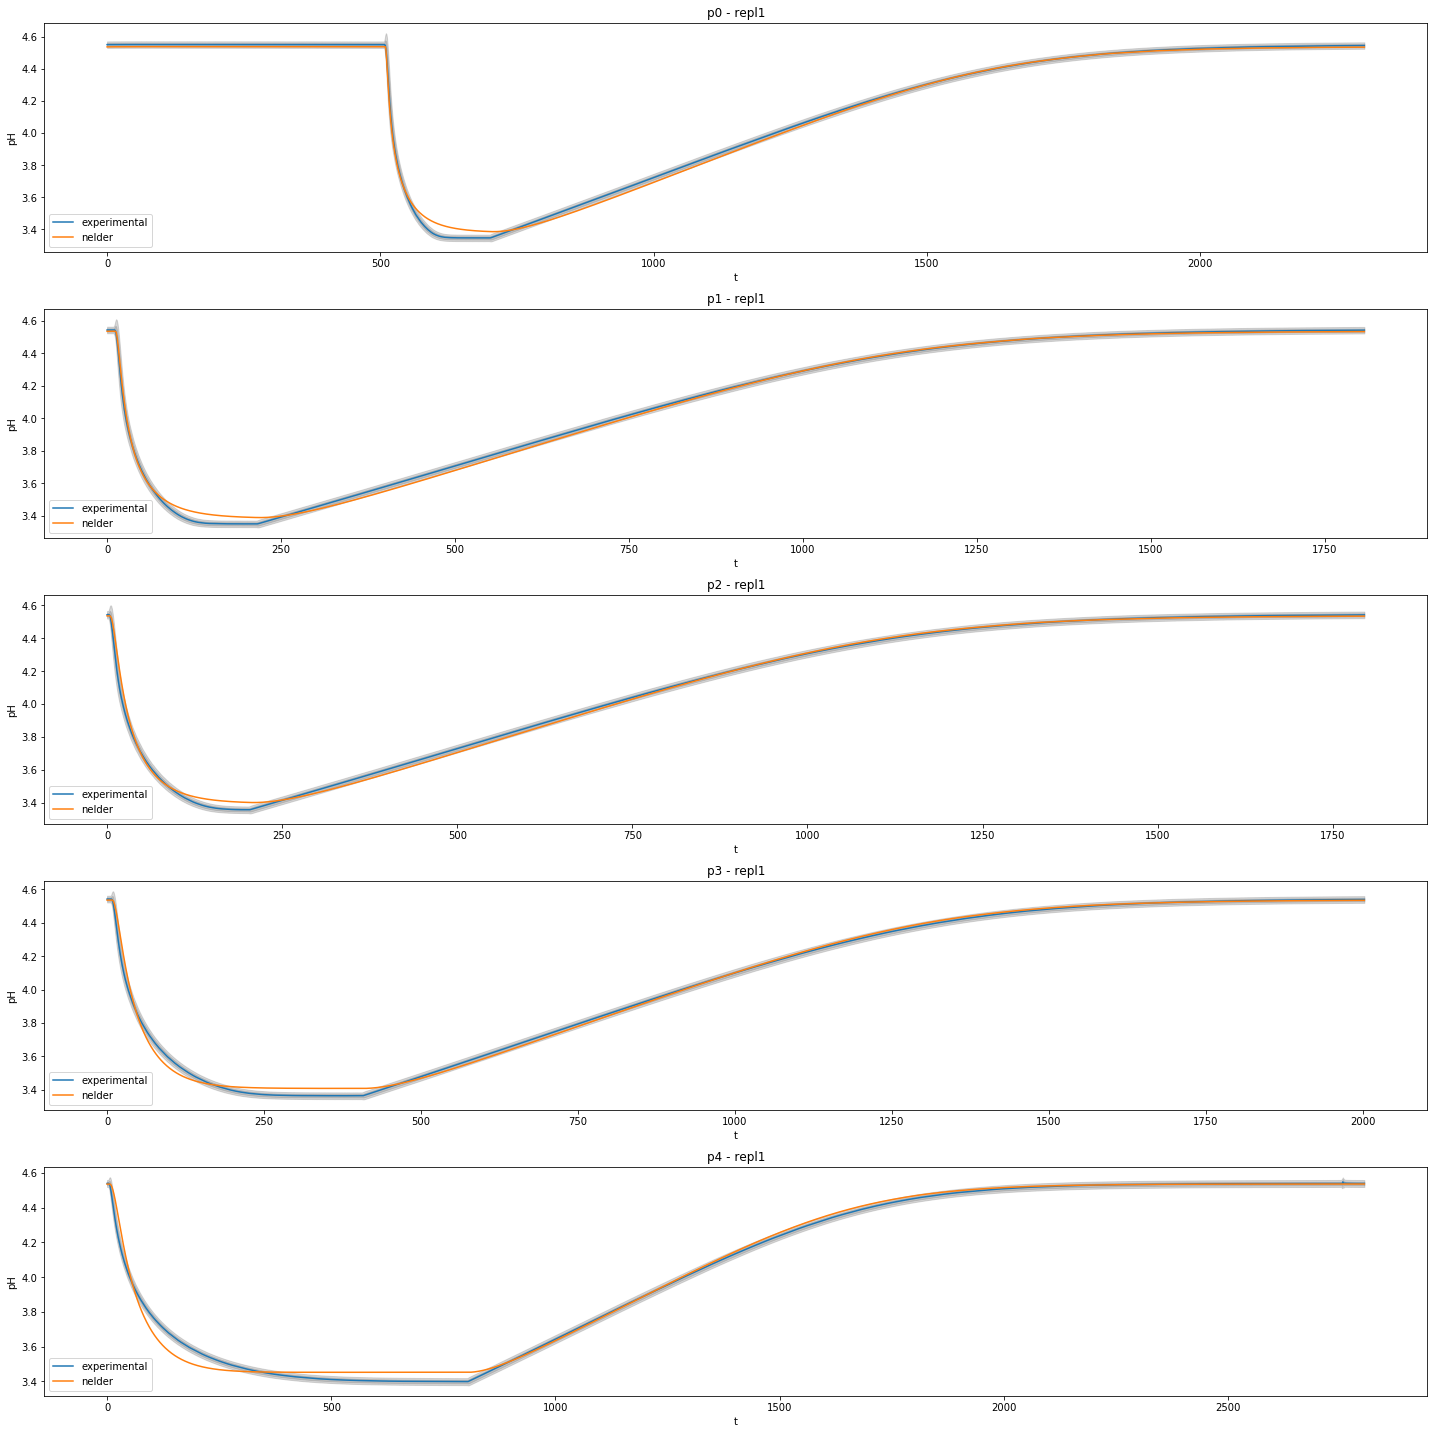

In [968]:
plotModel(modelvp,params=[ (best_params,'nelder') ],plots=[ [('t','pH')],[('t','pH')],[('t','pH')],[('t','pH')],[('t','pH')] ])
plt.savefig('n1_variablepower_pHjumps.png')

In [969]:
pw=[]
kpw=[]
for key in initialdata.keys():
    if len(key)>3 and key[:3]=='knu':
        print(key,best_params[key].value)
        pw.append(float(key[3:])*1e-3)
        kpw.append(best_params[key].value)

knu340 0.3556091944190678
knu272 0.1377650434080524
knu204 0.06127657481205295
knu136 0.03437047893022793
knu68 0.013515836734951048


In [970]:
print(best_params['Ctot_rep1'])
print(best_params['knu'])

<Parameter 'Ctot_rep1', value=0.0005243662313521025, bounds=[0.0:inf]>
<Parameter 'knu', value=0.3324343964487606 (fixed), bounds=[0.0:inf]>


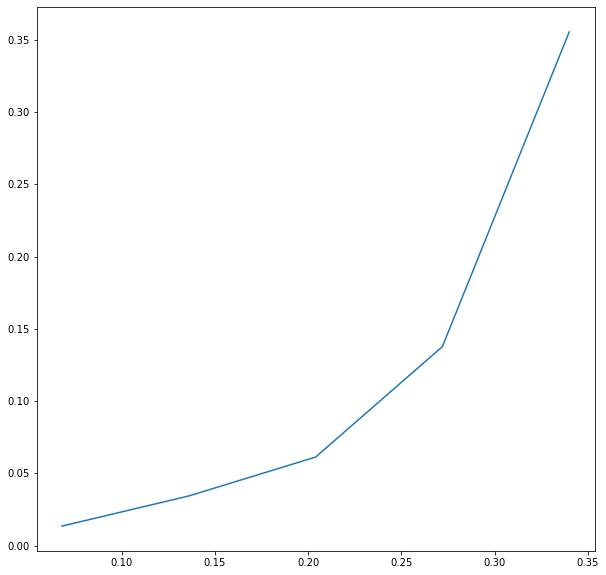

In [971]:
plt.plot(pw,kpw)
plt.savefig('n1_variablepower_knu.png')

In [972]:
best_params['k3']

<Parameter 'k3', value=2.2896189245606804 (fixed), bounds=[0.0:inf]>

In [ ]:
best_params['knu']